In [5]:
import numpy as np
import pandas as pd
import json

from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer


from sklearn.metrics.cluster import adjusted_rand_score

import matplotlib.pyplot as plt
from itertools import combinations

### 还原轨迹数据所需函数

In [6]:
def tr_fun(x,params):
    '''
    x: scalar,x-coordinate
    params: ndarray,weights
    module style: a0+a1*x+a2*x^2...
    '''
    x = np.array([x**i for i in range(len(params))])
    ret = np.dot(x,params)
    return ret

### 全局聚类所需函数

In [7]:
def df2array(df):
    # 将数据以 ndarray 的形式读入内存
    # [[x1,x2,...,x500,y1,y2,...,y500],[],...]
    i = 0
    data = np.array([])
    while i <= len(df)-1:
        arr_x = np.array(df['x'][i:i+500])
        arr_y = np.array(df['y'][i:i+500])
        arr = np.append(arr_x,arr_y)
        if len(data)==0:
            data = np.array([arr])
        else:
            data = np.append(data,[arr],axis=0)
        i+=500
    return data

In [8]:
# 确保定义的距离是有效的，非负性，同一性，对称性，直递性（三角不等式）

def dist(tr1,tr2):
    length = len(tr1)
    if not(length == 1000):
        # 传入参数形式为(k,1000)
        # 计算k个簇心点更新前后的距离
        distance = 0
        for i in range(length):
            pre = tr1[i]
            now = tr2[i]
            half = int(len(pre)/2)
            x1 = pre[0:half]
            y1 = pre[half:]
            x2 = now[0:half]
            y2 = now[half:]
            deta_x = x1 - x2
            deta_y = y1 - y2
            distance = distance + np.sum((deta_x**2 + deta_y**2) ** 0.5) / len(x1)
    else:       
        half = int(length/2)
        x1 = tr1[0:half]
        y1 = tr1[half:]
        x2 = tr2[0:half]
        y2 = tr2[half:]
        deta_x = x1 - x2
        deta_y = y1 - y2
        distance = np.sum((deta_x**2 + deta_y**2) ** 0.5) / len(x1)
        # print(distance)
    return distance

In [9]:
def cluster(data,K):

    metric = distance_metric(type_metric.USER_DEFINED, func=dist)
    initial_centers = kmeans_plusplus_initializer(data, K).initialize()

    kmeans_instance = kmeans(data, initial_centers, metric=metric)

    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    centers = kmeans_instance.get_centers()
    
    return clusters,centers

In [10]:
# ndarray中每个元素长度要相等
def getKmeansResult(data,K):
    clusters,centers = cluster(data,K)
    labels = np.zeros(NUM_TR)
    for i in range(K):
        for j in range(NUM_TR):
            if j in clusters[i]:
                labels[j] = i
    return labels,np.array(centers)

In [11]:
def cost(data,labels,centers):
    loss = 0
    for i in range(len(data)):
        loss = loss + dist(data[i],centers[int(labels[i])])
    loss = loss / len(data)
    return loss # 平均每个簇的损失

In [12]:
def chooseK(data,K):
    x = np.arange(3,K+1)
    y = np.zeros(len(x))
    for k in range(3,K+1):
        labels,centers = getKmeansResult(data,k)
        y[k-3] = cost(data, labels,centers)
    plt.plot(x,y)
    plt.xlabel('K')
    plt.ylabel('cost')
    plt.grid(True)
    plt.show()

### main

In [13]:
# resample 50 points each segment
def resample(tr_id,x_minmax,params):
    segment_num = len(params)
    global RESAMPLE_DATA
    matrix = np.zeros((segment_num * RESAMPLE_EACH_SEGMENT,3))
    matrix[:,0] = tr_id
    x = np.array([])
    y = np.array([])
    x_min = x_minmax[:,0]
    x_max = x_minmax[:,1]
    delta_x = (x_max - x_min)/RESAMPLE_EACH_SEGMENT
    for i in range(segment_num):
        lx = [x_min[i]+j*delta_x[i] for j in range(RESAMPLE_EACH_SEGMENT)]
        ly = [tr_fun(in_x,params[i]) for in_x in lx]
        x = np.append(x,lx)
        y = np.append(y,ly)
    matrix[:,1] = x
    matrix[:,2] = y

    if len(RESAMPLE_DATA) == 0:
        RESAMPLE_DATA = matrix
    else:
        RESAMPLE_DATA = np.append(RESAMPLE_DATA,matrix,axis = 0)

In [14]:
def para2df(file_name):
    global RESAMPLE_DATA
    global RESAMPLE_EACH_SEGMENT
    RESAMPLE_DATA = np.array([])
    with open(file_name,"r") as f:
        data=json.load(f)
    para_dic = json.loads(s=data)
    #######
    for k,v in para_dic.items():
        RESAMPLE_EACH_SEGMENT = int(500/len(v['x_minmax']))
        break
    #######
    print(RESAMPLE_EACH_SEGMENT)
    for k,v in para_dic.items():
        tr_id = k
        params = np.array(v['param'])
        x_minmax = np.array(v['x_minmax'])
        resample(tr_id,x_minmax,params)
    df = pd.DataFrame(RESAMPLE_DATA,columns=['person_id','x','y'])
    return df

In [15]:
def stableClustering(data,k):
    labels,centers = getKmeansResult(data,k)
    min_cost = cost(data,labels,centers)
    for i in range(50): # 取30次聚类中损失函数最小的
        labels_,centers_ = getKmeansResult(data,k)
        cost_ = cost(data,labels_,centers_)
        if cost_ < min_cost:
            labels = labels_
            centers = centers_
            min_cost = cost_
    print(min_cost)
    return labels,centers

In [16]:
# 对于抽样率不为1的实验，生成所有轨迹的分类结果
def allTraResult(centers):
    result = []
    for i in ALL_DATA:
        distArr = []
        for j in range(K):
            distArr.append(dist(np.array(i),np.array(centers[j])))
        minDist = np.min(distArr)
        result.append(distArr.index(minDist))
    return result

In [17]:
def RI(a,b):
    ss = 0
    dd = 0
    sum = 0
    for com in combinations(range(len(a)),2):
        sum = sum + 1
        if (a[com[0]] == a[com[1]]) and (b[com[0]] == b[com[1]]):
            ss = ss + 1
        if (a[com[0]] != a[com[1]]) and (b[com[0]] != b[com[1]]):
            dd = dd + 1
    return (ss + dd) / sum

In [18]:
RESAMPLE_EACH_SEGMENT = 0
RESAMPLE_DATA = np.array([])

In [19]:
all_df = pd.read_csv('./data/all.csv')
ALL_DATA = df2array(all_df)

### 加载第一个节点的参数文件

In [49]:
df1 = para2df('paraC1/node1para50.txt')

250


### 加载第二个节点参数文件

In [50]:
df2 = para2df('paraC1/node2para50.txt')

250


### 加载第三个节点参数文件

In [51]:
df3 = para2df('paraC1/node3para50.txt')

250


In [52]:
frames = [df1, df2, df3]

df = pd.concat(frames)

In [53]:
NUM_TR = int(len(df)/500)
NUM_TR

549

### 第一个实验：轨迹点数抽样

In [54]:
DATA50 = df2array(df)

In [48]:
DATA20 = df2array(df)

In [24]:
DATA10 = df2array(df)

In [42]:
DATA5 = df2array(df)

In [36]:
DATA2 = df2array(df)

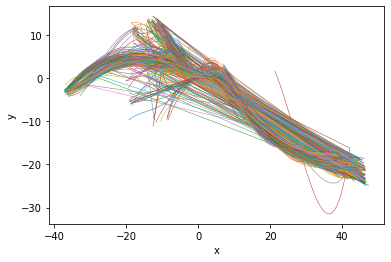

In [59]:
for i in range(len(DATA50)):
    x = DATA50[i][:500]
    y = DATA50[i][500:]
    plt.plot(x,y,linewidth=0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    
plt.show()

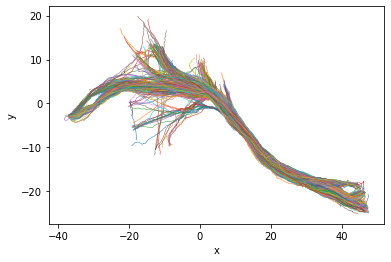

In [31]:
for i in range(len(ALL_DATA)):
    x = ALL_DATA[i][:500]
    y = ALL_DATA[i][500:]
    plt.plot(x,y,linewidth=0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    
plt.show()

In [58]:
K = 6

In [71]:
baseline = [3.0, 4.0, 1.0, 0.0, 0.0, 4.0, 4.0, 0.0, 2.0, 0.0, 5.0, 3.0, 1.0, 4.0, 1.0, 2.0, 0.0, 3.0, 0.0, 4.0, 1.0, 4.0, 1.0, 2.0, 5.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 4.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 5.0, 2.0, 1.0, 1.0, 5.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 5.0, 4.0, 0.0, 1.0, 0.0, 4.0, 4.0, 0.0, 4.0, 0.0, 0.0, 5.0, 0.0, 4.0, 0.0, 2.0, 1.0, 0.0, 3.0, 5.0, 1.0, 3.0, 0.0, 3.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 3.0, 0.0, 2.0, 0.0, 5.0, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 4.0, 0.0, 0.0, 1.0, 5.0, 3.0, 1.0, 5.0, 5.0, 3.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 5.0, 3.0, 2.0, 5.0, 1.0, 0.0, 3.0, 4.0, 4.0, 1.0, 2.0, 5.0, 0.0, 2.0, 2.0, 4.0, 1.0, 0.0, 4.0, 5.0, 3.0, 3.0, 4.0, 5.0, 4.0, 0.0, 4.0, 0.0, 0.0, 5.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 4.0, 5.0, 4.0, 1.0, 5.0, 4.0, 4.0, 3.0, 0.0, 5.0, 4.0, 4.0, 2.0, 0.0, 3.0, 5.0, 0.0, 0.0, 5.0, 1.0, 4.0, 2.0, 1.0, 1.0, 1.0, 4.0, 0.0, 1.0, 1.0, 0.0, 2.0, 4.0, 1.0, 1.0, 5.0, 4.0, 0.0, 0.0, 0.0, 3.0, 2.0, 0.0, 4.0, 0.0, 1.0, 3.0, 1.0, 3.0, 0.0, 3.0, 4.0, 4.0, 2.0, 5.0, 3.0, 3.0, 4.0, 4.0, 2.0, 1.0, 0.0, 0.0, 4.0, 0.0, 3.0, 0.0, 2.0, 3.0, 0.0, 5.0, 2.0, 5.0, 0.0, 3.0, 4.0, 3.0, 1.0, 5.0, 2.0, 0.0, 0.0, 5.0, 2.0, 4.0, 1.0, 0.0, 0.0, 5.0, 0.0, 1.0, 3.0, 0.0, 0.0, 1.0, 5.0, 1.0, 3.0, 0.0, 2.0, 2.0, 3.0, 1.0, 1.0, 5.0, 1.0, 5.0, 4.0, 1.0, 5.0, 0.0, 5.0, 2.0, 0.0, 3.0, 1.0, 1.0, 5.0, 0.0, 1.0, 1.0, 3.0, 0.0, 4.0, 0.0, 4.0, 5.0, 2.0, 0.0, 4.0, 4.0, 5.0, 4.0, 2.0, 0.0, 3.0, 3.0, 0.0, 0.0, 1.0, 0.0, 5.0, 0.0, 3.0, 5.0, 5.0, 4.0, 1.0, 5.0, 1.0, 1.0, 0.0, 3.0, 0.0, 1.0, 2.0, 2.0, 3.0, 3.0, 1.0, 2.0, 0.0, 5.0, 0.0, 1.0, 4.0, 4.0, 5.0, 4.0, 3.0, 1.0, 3.0, 5.0, 1.0, 5.0, 0.0, 5.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 5.0, 1.0, 0.0, 4.0, 4.0, 0.0, 3.0, 0.0, 5.0, 4.0, 4.0, 2.0, 4.0, 1.0, 5.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 5.0, 0.0, 5.0, 0.0, 1.0, 0.0, 0.0, 4.0, 4.0, 4.0, 2.0, 4.0, 5.0, 2.0, 5.0, 0.0, 1.0, 2.0, 1.0, 4.0, 1.0, 1.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, 0.0, 4.0, 0.0, 1.0, 2.0, 4.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0, 0.0, 3.0, 2.0, 2.0, 0.0, 3.0, 0.0, 0.0, 0.0, 4.0, 0.0, 5.0, 2.0, 0.0, 2.0, 5.0, 3.0, 3.0, 0.0, 2.0, 0.0, 5.0, 2.0, 2.0, 3.0, 1.0, 1.0, 2.0, 0.0, 5.0, 2.0, 4.0, 0.0, 4.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.0, 2.0, 0.0, 3.0, 0.0, 2.0, 3.0, 4.0, 0.0, 2.0, 0.0, 2.0, 5.0, 1.0, 2.0, 5.0, 0.0, 0.0, 3.0, 1.0, 0.0, 0.0, 1.0, 5.0, 3.0, 2.0, 4.0, 3.0, 3.0, 4.0, 0.0, 0.0, 4.0, 0.0, 5.0, 2.0, 5.0, 0.0, 0.0, 5.0, 4.0, 3.0, 1.0, 5.0, 3.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 5.0, 1.0, 0.0, 1.0, 4.0, 2.0, 0.0, 1.0, 1.0, 1.0, 2.0, 5.0, 4.0, 4.0, 2.0, 1.0, 0.0, 0.0, 0.0, 4.0, 2.0, 5.0, 1.0, 5.0, 0.0, 0.0, 5.0]

===================================================================

In [109]:
ri = 0
ari = 0
N = 5
for i in range(N):
    l50,centers = stableClustering(DATA50,K)
    ri = ri + RI(l50,baseline)
    ari = ari + adjusted_rand_score(l50,baseline)
    print(RI(l50,baseline),adjusted_rand_score(l50,baseline))
print(ri/N,ari/N)

4.045324880317209
0.9541036788852991 0.8479791877964915
4.045324880317209
0.9541036788852991 0.8479791877964915
4.045324880317209
0.9541036788852991 0.8479791877964915
4.045324880317209
0.9541036788852991 0.8479791877964915
4.069003835514857
0.9343065693430657 0.7821915554368299
0.9501442569768525 0.8348216613245591


In [110]:
ri = 0
ari = 0
N = 5
for i in range(N):
    l20,centers = stableClustering(DATA20,K)
    ri = ri + RI(l20,baseline)
    ari = ari + adjusted_rand_score(l20,baseline)
    print(RI(l20,baseline),adjusted_rand_score(l20,baseline))
print(ri/N,ari/N)

4.263261577903871
0.9784412269155598 0.9297354234499584
4.263261577903871
0.9784412269155598 0.9297354234499584
4.265704802074554
0.9932458484570487 0.9780761406108684
4.2648607360916175
0.9932325528831452 0.9780129570438785
4.258173961175273
0.9922220892664831 0.974694056840777
0.9871165888875593 0.9580508002790882


In [111]:
ri = 0
ari = 0
N = 5
for i in range(N):
    l10,centers = stableClustering(DATA10,K)
    ri = ri + RI(l10,baseline)
    ari = ari + adjusted_rand_score(l10,baseline)
    print(RI(l10,baseline),adjusted_rand_score(l10,baseline))
print(ri/N,ari/N)

4.28958827847308
0.9912515123715315 0.9715002538381394
4.299407594347817
0.9940834696129659 0.9807667062036272
4.292163021788649
0.9970882693151449 0.9905193651150805
4.292163021788649
0.9970882693151449 0.9905193651150805
4.292163021788649
0.9970882693151449 0.9905193651150805
0.9953199579859865 0.9847650110774016


In [112]:
ri = 0
ari = 0
N = 5
for i in range(N):
    l5,centers = stableClustering(DATA5,K)
    ri = ri + RI(l5,baseline)
    ari = ari + adjusted_rand_score(l5,baseline)
    print(RI(l5,baseline),adjusted_rand_score(l5,baseline))
print(ri/N,ari/N)

4.308250500780102
0.9823634212170769 0.9424784519293382
4.30120207603767
0.9890311515296558 0.9642622314480404
4.306804726217052
0.998218393096938 0.9942014008662114
4.301915182360172
0.9939438660869796 0.9802670934075026
4.31194986101921
0.9899950806376557 0.9673901088878369
0.9907103825136613 0.9697198573077859


In [113]:
ri = 0
ari = 0
N = 5
for i in range(N):
    l2,centers = stableClustering(DATA2,K)
    ri = ri + RI(l2,baseline)
    ari = ari + adjusted_rand_score(l2,baseline)
    print(RI(l2,baseline),adjusted_rand_score(l2,baseline))
print(ri/N,ari/N)

4.311215469152481
0.9966495153763312 0.9890863772705012
4.315329425698176
1.0 1.0
4.315281974921058
0.9591294058208023 0.866541055216738
4.31359302663942
0.9899950806376557 0.9673901088878369
4.30853062155703
0.998218393096938 0.9942014008662114
0.9887984789863454 0.9634437884482574


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [73]:
# 该实验说明，在原始数据集上的聚类结果与baseline一样
ri = 0
ari = 0
N = 1
for i in range(N):
    l,centers = stableClustering(ALL_DATA,K)
    ri = ri + RI(l,baseline)
    ari = ari + adjusted_rand_score(l,baseline)
print(ri/N,ari/N)

4.325291074096967
1.0 1.0


In [104]:
# 聚类直接产生的结果 VS. 通过簇心点来对全局数据打标签的结果
# 理应应该是一样的
ri = 0
ari = 0
N = 5
for i in range(N):
    l1,centers = getKmeansResult(ALL_DATA,K)
    l2 = allTraResult(centers)
    ri = ri + RI(l1,l2)
    ari = ari + adjusted_rand_score(l1,l2)
print(ri/N,ari/N)

1.0 1.0


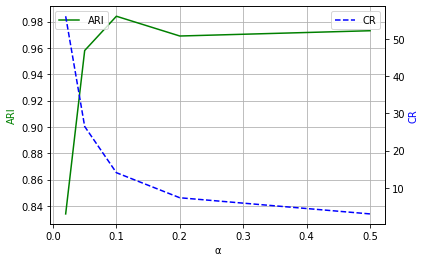

In [61]:
alpha = [1/50,1/20,1/10,1/5,1/2]
RI = [0.950 , 0.987 , 0.995 , 0.990 , 0.988]
ARI = [0.834, 0.958,0.984,0.969,0.973]
CR = [56.017, 26.452, 14.063 , 7.341, 3.008]
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()           # 做镜像处理N
ax1.plot(alpha,ARI,'g-',label='ARI')
ax2.plot(alpha,CR,'b--',label='CR')
 
ax1.set_xlabel("α")    #设置x轴标题
ax1.set_ylabel('ARI',color = 'g')   #设置Y1轴标题
ax2.set_ylabel('CR',color = 'b') 
ax2.legend(loc=1)
ax1.legend(loc=2)
ax1.grid()
plt.show()

### End